**Step 1 — Setup & Imports**

In [1]:
# Clean any old torch packages first
!pip -q uninstall -y torch torchvision torchaudio

# Install a matching trio (works on current Colab GPU)
!pip -q install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
  --index-url https://download.pytorch.org/whl/cu121

# Your extras
!pip -q install mediapipe==0.10.18 opencv-python-headless==4.10.0.84 \
  pywavelets==1.6.0 tqdm==4.66.5



In [2]:
import torch, torchvision, torchaudio, cv2, mediapipe as mp, pywt, numpy as np
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("opencv:", cv2.__version__)
print("mediapipe:", mp.__version__)
print("pywavelets:", pywt.__version__)
print("numpy:", np.__version__)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


torch: 2.5.1+cu121
torchvision: 0.20.1+cu121
torchaudio: 2.5.1+cu121
opencv: 4.11.0
mediapipe: 0.10.18
pywavelets: 1.6.0
numpy: 1.26.4


In [4]:
# --- COLAB SETUP ---

import os, sys, json, glob, math, random, shutil, time
from pathlib import Path
import numpy as np
import cv2
import mediapipe as mp
import pywt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image


step-2

In [5]:
# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- DEFINE ROOTS (edit these to your Drive paths) ---
DRIVE = Path('/content/drive/MyDrive/DeepfakeProject1')
DATA_IN   = DRIVE/'data'           # your original dataset (images in class subfolders: real/, fake/)
SBI_OUT   = DRIVE/'cache_sbi'           # SBI images will be saved here (class subfolders preserved)
DWT_OUT   = DRIVE/'cache_dwt'           # DWT images will be saved here (class subfolders preserved)
CKPT_DIR  = DRIVE/'models'        # model checkpoints

for p in [SBI_OUT, DWT_OUT, CKPT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Expected input structure:
# /MyDrive/deepfake_data/raw/real/*.jpg
# /MyDrive/deepfake_data/raw/fake/*.jpg
#
# Output mirrors this, e.g.
# /MyDrive/deepfake_data_sbi/real/xxx.jpg
# /MyDrive/deepfake_data_dwt/real/xxx.jpg


Mounted at /content/drive


1) Utilities (I/O, caching, helpers)

In [ ]:
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def list_images(root: Path):
    files = []
    for ext in IMG_EXT:
        files.extend(root.rglob(f'*{ext}'))
    return sorted([Path(p) for p in files])

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def same_relpath(src: Path, src_root: Path, dst_root: Path) -> Path:
    rel = src.relative_to(src_root)
    return dst_root/rel

def read_image(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f'Failed to read: {path}')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def write_image(path: Path, rgb):
    ensure_dir(path.parent)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(path), bgr)

def resize_long_edge(img, long=512):
    h, w = img.shape[:2]
    if max(h, w) == long:
        return img
    scale = long / max(h, w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)


** SBI Generation**

In [ ]:
# --- Required libs ---
import cv2, random, numpy as np
from pathlib import Path
from tqdm import tqdm
import mediapipe as mp

# --- MediaPipe FaceMesh handle (kept outside to avoid re-creating each call) ---
mp_face = mp.solutions.face_mesh

# -------- I/O helpers --------
IMG_EXT = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def list_images(root: Path):
    return [p for p in root.rglob('*') if p.suffix.lower() in IMG_EXT]

def read_image(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f'Failed to read: {path}')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def write_image(path: Path, rgb):
    ensure_dir(path.parent)
    cv2.imwrite(str(path), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))

def resize_long_edge(img, long=512):
    h, w = img.shape[:2]
    if max(h, w) == long: return img
    s = long / max(h, w)
    nh, nw = int(round(h*s)), int(round(w*s))
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

# -------- 1) Face pre-alignment (eyes -> horizontal) --------
def align_face_eye_based(img, out=512, eye_pos=(0.35, 0.35)):
    h, w = img.shape[:2]
    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if not res.multi_face_landmarks:
        return cv2.resize(img, (out, out))

    lm = res.multi_face_landmarks[0].landmark
    L_idxs = [33, 133, 159, 145]      # left eye region (approx)
    R_idxs = [362, 263, 386, 374]     # right eye region (approx)
    L = np.mean([[lm[i].x*w, lm[i].y*h] for i in L_idxs], axis=0)
    R = np.mean([[lm[i].x*w, lm[i].y*h] for i in R_idxs], axis=0)

    dx, dy = eye_pos[0]*out, eye_pos[1]*out
    eye_dist = np.linalg.norm(R - L)
    scale = (0.30*out) / (eye_dist + 1e-6)                 # keeps eye distance reasonable
    theta = np.degrees(np.arctan2(R[1]-L[1], R[0]-L[0]))   # rotate to horizontal

    M = cv2.getRotationMatrix2D(tuple(L), theta, scale)
    M[:,2] += [dx - L[0], dy - L[1]]

    return cv2.warpAffine(img, M, (out, out),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT_101)

# -------- 2) Refined inner-face mask + adaptive blur --------
def facial_hull_mask_refined(img):
    """Inner-face convex hull (exclude hair/ears) + adaptive blur by face size."""
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    with mp_face.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if not res.multi_face_landmarks:
        return None

    pts_all = np.array([[int(l.x*w), int(l.y*h)] for l in res.multi_face_landmarks[0].landmark])

    # inner-face indices: eyes, nose, cheeks, mouth (skip hairline/ears)
    key_idxs = list(range(70,150)) + list(range(150,200)) + list(range(200,280))
    pts = pts_all[key_idxs]

    if len(pts) < 3: return None
    hull = cv2.convexHull(pts)
    cv2.fillConvexPoly(mask, hull, 255)

    # light random translation for variety
    M = np.float32([[1,0,random.randint(-3,3)],[0,1,random.randint(-3,3)]])
    mask = cv2.warpAffine(mask, M, (w, h), borderValue=0)

    # gentle morphology to stabilize edges
    k3 = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, k3, iterations=random.randint(1,3))
    mask = cv2.erode(mask,  k3, iterations=random.randint(0,2))

    # --- adaptive blur: ~5% of face height (odd kernel, clamped 5..15) ---
    face_h = int(hull[:,0,1].max() - hull[:,0,1].min())
    k = int(max(5, min(15, face_h * 0.05)))
    if k % 2 == 0: k += 1
    mask = cv2.GaussianBlur(mask, (k, k), 0)

    return mask.astype(np.float32) / 255.0

# -------- 3) Shared geometry (same affine) + separate color jitter --------
def shared_geom_then_color(img):
    h, w = img.shape[:2]
    angle = random.uniform(-4, 4)
    scale = random.uniform(0.97, 1.03)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, scale)
    M[:,2] += [random.uniform(-4,4), random.uniform(-4,4)]  # small shift

    base = cv2.warpAffine(img, M, (w, h),
                          flags=cv2.INTER_LINEAR,
                          borderMode=cv2.BORDER_REFLECT_101)

    def color_jitter(x):
        x = x.astype(np.float32)
        b = random.uniform(0.92, 1.08)
        c = random.uniform(0.95, 1.05)
        m = x.mean(axis=(0,1), keepdims=True)
        x = np.clip((x - m) * c + m, 0, 255)
        x = np.clip(x * b, 0, 255).astype(np.uint8)
        return x

    Is = color_jitter(base)
    It = color_jitter(base.copy())
    return Is, It

# -------- 4) Alpha blending --------
def blend_sbi(Is, It, M):
    M3 = np.repeat(M[...,None], 3, axis=2)              # HxWx1 -> HxWx3
    out = Is.astype(np.float32)*M3 + It.astype(np.float32)*(1.0 - M3)
    return np.clip(out, 0, 255).astype(np.uint8)

# -------- 5) End-to-end SBI generator over folders (mirrors structure) --------
def run_sbi_generation_modified(src_root: Path, dst_root: Path, long_edge=512):
    files = list_images(src_root)
    print(f'Found {len(files)} images.')
    for fp in tqdm(files):
        outp = dst_root / fp.relative_to(src_root)   # mirror subfolders/filenames
        if outp.exists():                             # cache: skip existing
            continue

        img = read_image(fp)
        img = resize_long_edge(img, long_edge)
        img = align_face_eye_based(img, out=long_edge)         # 1) pre-align
        M   = facial_hull_mask_refined(img)                    # 2) refined mask
        if M is None:
            out = img
        else:
            Is, It = shared_geom_then_color(img)               # 3) same geometry
            out = blend_sbi(Is, It, M)                         # 4) blend

        write_image(outp, out)


In [ ]:
from pathlib import Path

SRC = Path('/content/drive/MyDrive/DeepfakeProject1/data')   # e.g., raw/real and raw/fake
DST = Path('/content/drive/MyDrive/DeepfakeProject1/cache_sbi')  # SBI output (mirrors folders)

run_sbi_generation_modified(SRC, DST, long_edge=512)


Found 8187 images.


100%|██████████| 8187/8187 [54:39<00:00,  2.50it/s]


** DWT implementation**

In [ ]:
import cv2, pywt, numpy as np

def fsbi_dwt(rgb, wavelet='sym2', mode='reflect',
             strategy='ca_avg', level=1):
    """
    rgb: uint8 HxWx3
    strategy:
      - 'ca_avg' : upsample CA and average with original channel (paper exact)
      - 'high3'  : stack (LH, HL, HH) magnitude as 3-ch output
      - 'swt_ca' : SWT level-1 CA (A1) upsampled + channel
      - 'swt_hf' : SWT level-1 (H1,V1,D1) magnitude stacked
    """
    x = rgb.astype(np.float32) / 255.0
    H, W = x.shape[:2]

    def to_uint8(img):
        img = np.clip(img, 0, 1)*255.0
        return img.astype(np.uint8)

    if strategy == 'high3':
        # classic high-frequency emphasis (downsampled, then resized)
        chans = []
        for ch in cv2.split(x):
            LL, (LH, HL, HH) = pywt.dwt2(ch, wavelet=wavelet, mode=mode)
            hf = np.stack([LH, HL, HH], -1)
            hf = np.abs(hf)
            hf = hf / (hf.max() + 1e-6)
            hf = cv2.resize(hf, (W, H), interpolation=cv2.INTER_LINEAR)
            chans.append(hf)
        out = np.mean(np.stack(chans,0), axis=0)   # average RGB HF
        return to_uint8(out)

    elif strategy == 'ca_avg':
        # paper-exact: per-channel CA averaged with original channel
        out = []
        for ch in cv2.split(x):  # R,G,B
            LL, _ = pywt.dwt2(ch, wavelet=wavelet, mode=mode)
            LL_up = cv2.resize(LL, (W, H), interpolation=cv2.INTER_LINEAR)
            fused = 0.5*(LL_up + ch)
            out.append(fused)
        out = np.stack([out[0], out[2], out[1]], -1)  # [C_AR, C_AB, C_AG]
        return to_uint8(out)

    elif strategy in ['swt_ca','swt_hf']:
        # Stationary Wavelet Transform level=1 (no downsampling)
        out = []
        for ch in cv2.split(x):
            A, (Hh, Vv, Dd) = pywt.swt2(ch, wavelet=wavelet, level=1, start_level=0, axes=(-2,-1))
            A, (Hh, Vv, Dd) = A, (Hh, Vv, Dd)  # same size as input
            if strategy == 'swt_ca':
                fused = 0.5*(A + ch)
                out.append(fused)
            else:  # 'swt_hf'
                hf = np.stack([np.abs(Hh), np.abs(Vv), np.abs(Dd)], -1)
                hf = hf / (hf.max() + 1e-6)
                out.append(hf)
        if strategy == 'swt_ca':
            out = np.stack([out[0], out[2], out[1]], -1)
        else:  # swt_hf: average HF across channels
            out = np.mean(np.stack(out,0), axis=0)
        return to_uint8(out)

    else:
        raise ValueError('Unknown strategy')


Using image: /content/drive/MyDrive/DeepfakeProject1/cache_sbi/real/144_d52_dup1.png


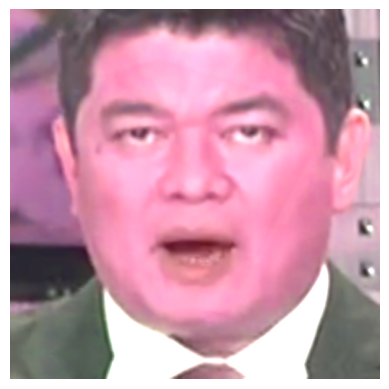

In [ ]:
from pathlib import Path

folder = Path('/content/drive/MyDrive/DeepfakeProject1/cache_sbi/real')
img_path = next(folder.glob('*.png'))  # or '*.png'
print('Using image:', img_path)

rgb = read_image(img_path)
dimg = fsbi_dwt(rgb, wavelet='sym2', mode='reflect', strategy='ca_avg')

import matplotlib.pyplot as plt
plt.imshow(dimg)
plt.axis('off')
plt.show()


In [ ]:
from pathlib import Path
from tqdm import tqdm
import os, cv2, numpy as np

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def list_images(root: Path):
    exts = ('.jpg', '.jpeg', '.png', '.bmp')
    return [p for p in root.rglob('*') if p.suffix.lower() in exts]

def run_dwt_folder_recursive(src_root: Path, dst_root: Path):
    """
    Read images from all subfolders under src_root (e.g., real/, fake/),
    apply fsbi_dwt(), and save outputs into mirrored structure under dst_root.
    """
    files = list_images(src_root)
    print(f'Found {len(files)} images.')

    for fp in tqdm(files):
        # mirror path to destination
        rel = fp.relative_to(src_root)
        outp = dst_root / rel
        ensure_dir(outp.parent)

        if outp.exists():
            continue

        try:
            rgb = read_image(fp)
            dimg = fsbi_dwt(rgb, wavelet='sym2', mode='reflect', strategy='ca_avg')
            cv2.imwrite(str(outp), cv2.cvtColor(dimg, cv2.COLOR_RGB2BGR))
        except Exception as e:
            print(f'⚠️ Skipped {fp}: {e}')


In [ ]:
SRC = Path('/content/drive/MyDrive/DeepfakeProject1/cache_sbi')
DST = Path('/content/drive/MyDrive/DeepfakeProject1/cache_dwt')

run_dwt_folder_recursive(SRC, DST)


Found 8187 images.


100%|██████████| 8187/8187 [13:12<00:00, 10.33it/s]


8) Model (MobileNetV3-Small) + training loop with best checkpoint

In [20]:
# --- PATHS ---
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/cache_dwt'        # has real/ and fake/
WORK_DIR = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3'    # outputs here
MODEL_BEST = f'{WORK_DIR}/mobilenetv3_best.pt'
SPLIT_JSON = f'{WORK_DIR}/split.json'

# --- TRAINING HYPERPARAMS ---
IMG_SIZE = 224
BATCH = 32
EPOCHS = 15
LR = 3e-4
VAL_RATIO = 0.15
TEST_RATIO = 0.15
SEED = 42

import os, json, numpy as np, torch, random
from pathlib import Path
Path(WORK_DIR).mkdir(parents=True, exist_ok=True)
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [16]:
from torchvision import datasets
from sklearn.model_selection import train_test_split

if not Path(SPLIT_JSON).exists():
    ds_all = datasets.ImageFolder(DATA_DIR)
    labels = [y for _,y in ds_all.samples]
    idx_all = np.arange(len(labels))

    idx_trainval, idx_test = train_test_split(
        idx_all, test_size=TEST_RATIO, stratify=labels, random_state=SEED
    )
    labels_trainval = [labels[i] for i in idx_trainval]
    idx_train, idx_val = train_test_split(
        idx_trainval, test_size=VAL_RATIO/(1.0-TEST_RATIO),
        stratify=labels_trainval, random_state=SEED
    )
    split = {'classes': ds_all.classes,
             'train': idx_train.tolist(),
             'val': idx_val.tolist(),
             'test': idx_test.tolist()}
    with open(SPLIT_JSON,'w') as f: json.dump(split, f, indent=2)
else:
    with open(SPLIT_JSON) as f: split = json.load(f)

print('Classes:', split['classes'])
print('Counts:', {k:len(split[k]) for k in ['train','val','test']})


Classes: ['fake', 'real']
Counts: {'train': 5730, 'val': 1228, 'test': 1229}


In [18]:
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# (optional) on-the-fly DWT wrapper — replace `pass` with your fsbi_dwt if needed
class ApplyDWT(object):
    def __call__(self, img):
        # rgb = np.array(img.convert('RGB')); dimg = fsbi_dwt(rgb, 'sym2', 'reflect', 'ca_avg')
        # return Image.fromarray(dimg)
        return img  # <- no-op if you already saved DWT images

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    base_tfm = weights.transforms()
except:
    base_tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

train_tfm = transforms.Compose([ApplyDWT(), base_tfm])
val_tfm   = transforms.Compose([ApplyDWT(), base_tfm])

ds_train_all = datasets.ImageFolder(DATA_DIR, transform=train_tfm)
ds_val_all   = datasets.ImageFolder(DATA_DIR, transform=val_tfm)

train_loader = DataLoader(Subset(ds_train_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_val_all,   split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_val_all,   split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# Positive class index for metrics (we treat 'fake' as positive)
pos_idx = ds_train_all.class_to_idx.get('fake', 1)
pos_idx


0

In [19]:
import torch.nn as nn
import torch.optim as optim

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_f, 2)
model = model.to(device)

# class weights to help recall on fake (auto-compute from split)
train_labels = [ds_train_all.samples[i][1] for i in split['train']]
w_real = (len(train_labels) / (2 * train_labels.count(0) + 1e-6))
w_fake = (len(train_labels) / (2 * train_labels.count(1) + 1e-6))
weights_cls = torch.tensor([w_real, w_fake], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights_cls)  # or drop weight if already balanced

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


/tmp/ipython-input-4062889267.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [21]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import math, torch

def eval_loader(loader):
    model.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            prob_pos = torch.softmax(logits, dim=1)[:, pos_idx]
            y_prob.extend(prob_pos.detach().cpu().numpy())
            y_true.extend(y.detach().cpu().numpy())
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob > 0.5).astype(int)
    # map so positive class is 1
    if pos_idx == 0: y_true = 1 - y_true
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return acc, f1, auc

best_f1 = -math.inf
patience, bad = 7, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for x, y in tqdm(train_loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item() * y.size(0)

    scheduler.step()
    tr_loss = running / len(train_loader.dataset)
    val_acc, val_f1, val_auc = eval_loader(val_loader)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss {tr_loss:.4f} | "
          f"val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | val_auc {val_auc:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1; bad = 0
        torch.save({'model_state': model.state_dict(),
                    'classes': split['classes'],
                    'pos_idx': pos_idx},
                   MODEL_BEST)
        print(f"  ✓ Saved best to {MODEL_BEST} (val_f1={val_f1:.4f})")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 01/15 | loss 0.5314 | val_acc 0.6596 | val_f1 0.5082 | val_auc 0.8091
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.5082)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 02/15 | loss 0.3414 | val_acc 0.6474 | val_f1 0.4621 | val_auc 0.8711


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 03/15 | loss 0.2259 | val_acc 0.7565 | val_f1 0.6952 | val_auc 0.9028
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.6952)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 04/15 | loss 0.1658 | val_acc 0.8306 | val_f1 0.8347 | val_auc 0.9041
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8347)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 05/15 | loss 0.1092 | val_acc 0.8632 | val_f1 0.8576 | val_auc 0.9391
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8576)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 06/15 | loss 0.0740 | val_acc 0.8200 | val_f1 0.8386 | val_auc 0.9285


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 07/15 | loss 0.0635 | val_acc 0.8697 | val_f1 0.8655 | val_auc 0.9344
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8655)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 08/15 | loss 0.0570 | val_acc 0.8550 | val_f1 0.8479 | val_auc 0.9324


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 09/15 | loss 0.0730 | val_acc 0.8844 | val_f1 0.8823 | val_auc 0.9525
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8823)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 10/15 | loss 0.0331 | val_acc 0.8844 | val_f1 0.8788 | val_auc 0.9490


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 11/15 | loss 0.0245 | val_acc 0.8893 | val_f1 0.8898 | val_auc 0.9509
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8898)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 12/15 | loss 0.0460 | val_acc 0.8713 | val_f1 0.8640 | val_auc 0.9421


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 13/15 | loss 0.0266 | val_acc 0.8974 | val_f1 0.8959 | val_auc 0.9553
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.8959)


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 14/15 | loss 0.0068 | val_acc 0.8917 | val_f1 0.8891 | val_auc 0.9560


  0%|          | 0/180 [00:00<?, ?it/s]/tmp/ipython-input-601794735.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 15/15 | loss 0.0202 | val_acc 0.8982 | val_f1 0.9007 | val_auc 0.9562
  ✓ Saved best to /content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt (val_f1=0.9007)


Test within dataset
1) Load split + build loaders

In [7]:
from pathlib import Path
import json, torch, torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- paths ---
DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/cache_dwt'        # has real/ and fake/
SPLIT_JSON = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/split.json'
MODEL_BEST = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt'
BATCH = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- read the split (classes, train/val/test indices) ---
with open(SPLIT_JSON) as f:
    split = json.load(f)
print('Classes in split:', split['classes'])   # ['fake','real']

# --- dataset (single ImageFolder over real/ and fake/) ---
# use the same normalization you trained with (ImageNet for MobileNetV3)
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    tfm = weights.transforms()
except:
    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

ds_all = datasets.ImageFolder(DATA_DIR, transform=tfm)
print('Classes from ImageFolder:', ds_all.classes)  # should match split['classes'] order

# --- build loaders from indices ---
train_loader = DataLoader(Subset(ds_all, split['train']), batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(Subset(ds_all, split['val']),   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(Subset(ds_all, split['test']),  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print('Counts -> train/val/test:', len(split['train']), len(split['val']), len(split['test']))


Mounted at /content/drive
Classes in split: ['fake', 'real']
Classes from ImageFolder: ['fake', 'real']
Counts -> train/val/test: 5730 1228 1229


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy : 0.8804
Precision: 0.8752
Recall   : 0.8880
F1-score : 0.8815
AUC      : 0.9536
Confusion Matrix:
 [[535  78]
 [ 69 547]]

Detailed report:
               precision    recall  f1-score   support

        real       0.89      0.87      0.88       613
        fake       0.88      0.89      0.88       616

    accuracy                           0.88      1229
   macro avg       0.88      0.88      0.88      1229
weighted avg       0.88      0.88      0.88      1229



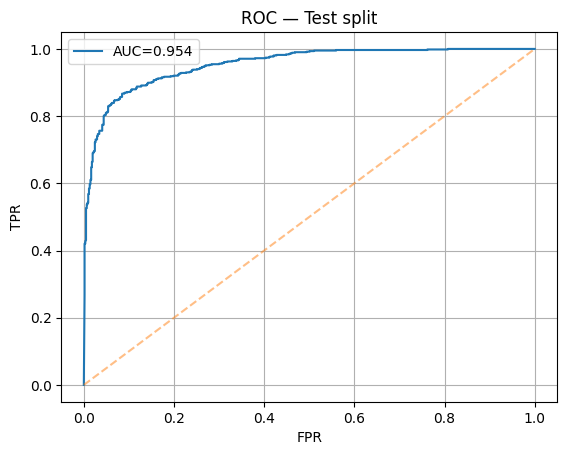

In [8]:
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
import numpy as np, matplotlib.pyplot as plt

# --- rebuild *exact* architecture used at training ---
model = mobilenet_v3_small(weights=None)
in_feats = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_feats, 2)

ckpt = torch.load(MODEL_BEST, map_location=device)
model.load_state_dict(ckpt['model_state'] if 'model_state' in ckpt else ckpt)
model.to(device).eval()

# positive class index for AUC (in your split/classes, 'fake' is index 0)
pos_idx = ds_all.class_to_idx['fake']

y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob_pos = torch.softmax(logits, dim=1)[:, pos_idx].cpu().numpy()
        y_prob.extend(prob_pos)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

# ensure "positive" label is 1 for metrics if needed
if pos_idx == 0:
    y_true = 1 - y_true

acc  = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
auc  = roc_auc_score(y_true, y_prob)
cm   = confusion_matrix(y_true, y_pred)

print(f'Accuracy : {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall   : {rec:.4f}')
print(f'F1-score : {f1:.4f}')
print(f'AUC      : {auc:.4f}')
print('Confusion Matrix:\n', cm)
print('\nDetailed report:\n', classification_report(y_true, y_pred, target_names=['real','fake']))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Test split'); plt.legend(); plt.grid(); plt.show()


Check the model by another dataset:

Mounted at /content/drive
Classes (alphabetical): ['fake', 'real']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Class mapping: {0: 'fake', 1: 'real'}
              precision    recall  f1-score   support

        fake       0.61      0.65      0.63       300
        real       0.64      0.60      0.62       310

    accuracy                           0.62       610
   macro avg       0.63      0.63      0.62       610
weighted avg       0.63      0.62      0.62       610

Confusion Matrix:
 [[196 104]
 [125 185]]
AUC: 0.6699


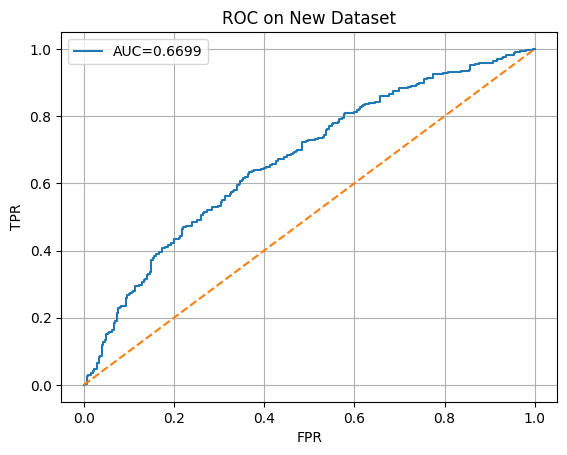

In [2]:
from pathlib import Path
import json, torch, torch.nn as nn
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# ==== paths ====
NEW_DATA_DIR = '/content/drive/MyDrive/DeepfakeProject1/B_cache_dwt'  # must contain real/ and fake/
MODEL_BEST   = '/content/drive/MyDrive/DeepfakeProject1/models/exp_mnv3/mobilenetv3_best.pt'
IMG_SIZE = 224
BATCH = 32

# ==== setup (same transforms as training) ====
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
try:
    tfm = weights.transforms()
except:
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])

ds = datasets.ImageFolder(root=NEW_DATA_DIR, transform=tfm)
test_loader = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
print('Classes (alphabetical):', ds.classes)  # e.g. ['fake', 'real'] or ['real','fake']

# ==== rebuild the model and load checkpoint ====
model = mobilenet_v3_small(weights=weights)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, 2)
ckpt = torch.load(MODEL_BEST, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device).eval()

# ==== inference & metrics ====
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support

y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob_fake = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # class index 1
        y_prob.extend(prob_fake); y_true.extend(y.numpy())

y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)



print('Class mapping:', {i:c for i,c in enumerate(ds.classes)})
print(classification_report(y_true, y_pred, target_names=ds.classes))
print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
auc = roc_auc_score(y_true, y_prob); print(f'AUC: {auc:.4f}')

fpr,tpr,_ = roc_curve(y_true, y_prob)
plt.plot(fpr,tpr,label=f'AUC={auc:.4f}'); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC on New Dataset'); plt.grid(True); plt.show()
